# Short-Term Crude Oil Scheduling using State-Task Networks and MILP

#### Dalton Flynn and Alexander Smith

CBE 40455: Final Project  
December 14, 2017

<a id='TC'></a>
## Table of Contents: ###

1.  [Introduction](#Intro)  
2.  [Refinery Problem Set-Up](#RPSU)
3.  [Creating a Pyomo Model](#CPM)
4.  [Solution of the Pyomo Model for Baseline Conditions](#Baseline)
5.  [Pump 1 Flowrate Capacity](#P1)
6.  [Pump 2 and Pump 3 Flowrate Capacity](#P23)
7.  [Settling Time](#ST)
8.  [Cost of Tank Use](#CTU)
9.  [Conclusion](#Conclusion)
10. [References](#Ref)

[Appendix: Utilizing McCormick Envelope](#APDX)

<a id='Intro'></a>
## 1. Introduction

This project is motivated by and adapted from a paper called “Mixed-Integer Programming Approach for Short-Term Crude Oil Scheduling” published by L.F.L Moro and J.M. Pinto in 2004. In this paper, Moro and Pinto address the problem of crude oil inventory management of a real-world refinery that receives oil delivered through a pipeline.

Refineries often receive crude oil feed through a pipeline, which is linked to a docking station where oil tankers unload. The schedule of oil tankers is usually defined at the corporate level and cannot be modified by the refinery scheduler under normal conditions. Therefore, for a given short-term scheduling horizon, a refinery faces a set oil batch schedule [Moro and Pinto, 2004]. This project aims to optimize a refinery's profit over a time horizon of 1.5 days (36 hours) given a set schedule of oil shipments, a simple refinery composed of 4 crude storage tanks, 3 pumps and piping, and 1 distillation unit, and certain operational constraints that will be elaborated upon below.

Following the lead of Moro and Pinto, a Mixed-Integer Linear Programming approach is utilized here to optimize refinery profit. Additionally, a State-Task Network (STN) approach in discretized time is used to model the movement of crude from oil tanker to crude tank to distillation unit. The STN is an approach to modeling multipurpose batch processes for the purpose of short-term scheduling. It was first developed by Kondili, et al., in 1993, and subsequently developed and extended by others. The system is modeled here in Pyomo and solved by the Gurobi Optimizer. This notebook begins from Professor J.C. Kantor's notebook "Scheduling Multipurpose Batch Processes using State-Task Networks" and builds in extra constraints and features, which will be described below.

<a id='RPSU'></a>
## 2. Refinery Problem Set-Up

[Link to Table of Contents](#TC)


**The State-Task Network:**  
A state-task network is a graphical representation of the activities in a multiproduct batch process. The representation includes the minimum details needed for short term scheduling of batch operations.

Each circular node in the diagram designates material in a particular state.  The materials are generally held in suitable vessels with a known capacity. The relevant information for each state is the initial inventory, storage capacity, and the unit price of the material in each state. For this refinery example, there are seven states: crude on the oil tanker before it has been unloaded (denoted the 'ship' state), crude in each of four tanks (denoted 'T1', 'T2', 'T3', and 'T4'), crude that has been fed to the distillation unit (denoted 'F_DU'), and the bottoms and distillate products leaving the distillation unit (denoted 'DandB'). 

The rectangular nodes denote process tasks. When scheduled for execution, each task is assigned an appropriate piece of equipment, and assigned a batch of material according to the incoming arcs. Each incoming arc begins at a state where the associated label indicates the mass fraction of the batch coming from that particular state. Outgoing arcs indicate the disposition of the batch to product states. The outgoing arc labels indicate the fraction of the batch assigned to each product state, and the time necessary to produce that product. The tasks in this example take 3 forms: pumping to a crude tank (denoted by the form 'PtoTX' where X is any tank number); pumping to the distillation unit from any of the crude tanks (denoted by the form 'PtoDUfTX' where X is any tank number); and distilling crude (denoted by 'distill').

Not shown in a STN diagram is the process equipment used to execute the tasks. A separate list of process units is available, each characterized by a capacity and list of tasks which can be performed in that unit. For this example, there is one pump (denoted as 'Pump1') that is able to complete tasks of sending crude from a tanker to any of the crude tanks. Additionally, there are two pumps ('Pump2' and 'Pump3') that are capable of sending crude from a crude tank to the distillation unit. Finally, there is one distillation unit (denoted as 'DU') capable of performing the distillation task.

**Additional information relevant to this problem:**  

The following constraints must be followed for any set-up of the refinery:
* The volume of a crude tank cannot drop below 20% of its maximum capacity. This is because the tanks employed are floating-roof tanks in order to minimize losses to vaporization within the tank.    
* The distilation unit has a maximum capacity of 2000 $m^3$.  
* A pumping cost of \$900 per $m^3$ is assigned.  
* The distillation unit can distill a maximum of 2000 $m^3$/hr of crude. Additionally, it must distill at least 1000 $m^3$/hr.    
* The price of refined crude (distillate and bottoms product) is calculated as weighted average of revenues available from gasoline, diesel, and jet fuel. It comes to roughly \$866/$m^3$.  
* The shipment schedule within the 36 hour time horizon is: 1) at time 6, 10,000 $m^3$ of crude arrive; 2) at time 12, 15,000 $m^3$ of crude arrive; 3) at time 24, 25,000 $m^3$ of crude arrive. Additionally, the initial tank inventories are as follows: T1 - 15,000 $m^3$; T2 - 20,000 $m^3$; T3 - 20,000 $m^3$; T4 - 15,000 $m^3$

The following constraints are included in the "baseline" model but are altered to explore possible returns on investments into improving the refinery:
* Pump1 can pump at a rate of 3500 $m^3$/hr while Pump2 and Pump3 can pump at rates of 1000$m^3$/hr.
* A brine settling time of 3 hours is required. Changing this amount of time is explored in the example.  
* The cost of using a tank is assumed to be \$4,000,000. This is to pay for 24/7 operators to sample from and perform maintenance on the tank. This also pays for maintenance and parts on the tank. It also includes opportunity cost for the space the tank takes up.

** Below is a dictionary composed of the states, tasks, units, and arcs tying them together. This dictionary also all of the baseline parameters described in the bulleted lists above. In Figure 1 below this dictionary is the STN diagram. **

In [1]:
H = 36 # hours

con = 0 # cost to turn pump on
cvar = 900 # cost for each m^3 pumped
tankcost = 4e6

tpump = 1 # hrs to pump vpump1 and vpump2
tstill = 1 # hrs to distill 2000 m^3
vpump1 = 3.5 # volume per hour of pump 1 in thousands of m^3
vpump2 = 1 # volume per hour of pump 2 and pump 3 in thousands of m^3

distvol = 2 # max flowrate in thousands of m^3/hr the distillation column can handle
distmin = 1 # min flowrate in thousands of m^3/hr the distillation column can handle

tsettle = 3 # hrs required for brine to settle in crude before it can be sent to the distillation unit (DU)

shiploads = {6:10,
            12:15,
            24:25} # key:value is time:amount of crude shipment
pdcrude = ((20/36)*2.5+(12/36)*3+(4/36)*8)*(264.172)*1000 # dollar per m^3 of product
# https://www.eia.gov/energyexplained/index.cfm?page=oil_refining

# all amounts are in thousands
Kondili = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Ship'     : {'capacity': 200  , 'minimum': 0   ,'initial': 15  , 'price':  0},
        'T1'       : {'capacity': 50   , 'minimum': 10  ,'initial': 20  , 'price':  0},
        'T2'       : {'capacity': 50   , 'minimum': 10  ,'initial': 20 , 'price':  0},
        'T3'       : {'capacity': 50   , 'minimum': 10  ,'initial': 20  , 'price':  0},
        'T4'       : {'capacity': 50   , 'minimum': 10  ,'initial': 15  , 'price':  0},
        'F_DU'     : {'capacity': distvol    , 'minimum': 0   ,'initial': distvol   , 'price':  0},
        'DandB'    : {'capacity': 400  , 'minimum': 0   ,'initial': 0   , 'price': pdcrude}
    },
    'ST_ARCS': {
        ('Ship'  ,   'PtoT1')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT2')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT3')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT4')     : {'rho': 1.0},
        ('T1'    ,   'PtoDUfT1')  : {'rho': 1.0},
        ('T2'    ,   'PtoDUfT2')  : {'rho': 1.0},
        ('T3'    ,   'PtoDUfT3')  : {'rho': 1.0},
        ('T4'    ,   'PtoDUfT4')  : {'rho': 1.0},
        ('F_DU'  ,   'Distill')   : {'rho': 1.0}
    },
    'TS_ARCS': {
        ('PtoT1'     , 'T1')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT2'     , 'T2')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT3'     , 'T3')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT4'     , 'T4')       : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT1'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT2'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT3'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT4'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('Distill'   , 'DandB')    : {'dur': tstill, 'rho': 1.0}
    },
    'UNIT_TASKS': {
        ('Pump1'    , 'PtoT1')     : {'Bmin': 0, 'Bmax': vpump1, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT2')     : {'Bmin': 0, 'Bmax': vpump1, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT3')     : {'Bmin': 0, 'Bmax': vpump1, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT4')     : {'Bmin': 0, 'Bmax': vpump1, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT1')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT1')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT2')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT2')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT3')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT3')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT4')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT4')  : {'Bmin': 0, 'Bmax': vpump2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('DU'       , 'Distill')   : {'Bmin': 1, 'Bmax': distvol, 'Cost': 0  , 'vCost': 0   , 'Tclean': 0}
    },
}

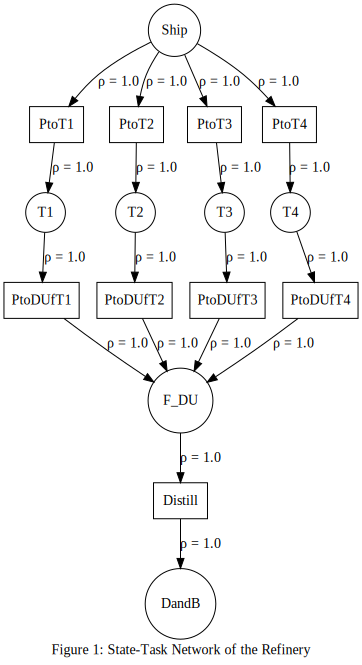

In [2]:
# create STN flowchart from nodes input
from graphviz import Digraph

dot = Digraph()
#dot.graph_attr['rankdir'] = 'LR'
dot.graph_attr['label'] = 'Figure 1: State-Task Network of the Refinery'
dot.graph_attr['labeljust'] = 'centered'
dot.graph_attr['labelloc'] = 'b'
dot.graph_attr['fontsize'] = '14'

for s in Kondili['STATES']:
    dot.node(s,s,shape='circle')
    
for i in sorted(Kondili['UNIT_TASKS']):
    dot.node(i[1],i[1],shape='box')

for i in sorted(Kondili['ST_ARCS'].keys()):
    s = i[0]
    t = i[1]
    dot.edge(s,t,label='ρ = '+str(Kondili['ST_ARCS'][i]['rho']))

for i in Kondili['TS_ARCS'].keys():
    t = i[0]
    s = i[1]
    dot.edge(t,s,label='ρ = '+str(Kondili['TS_ARCS'][i]['rho']))
    

dot

<a id='CPM'></a>
## 3. Creating a Pyomo Model
[Link to Table of Contents](#TC)

The following Pyomo model closely follows the development in Kondili, et al. (1993). In particular, the first step in the model is to process the STN data to create sets as given in Kondili.  

One important difference from Kondili is the adoption of a more natural time scale that starts at $t = 0$ and extends to $t = H$ (rather than from 1 to H+1).

A second difference is the introduction of an additional decision variable denoted by $Q_{j,t}$ indicating the amount of material in unit $j$ at time $t$. A material balance then reads

\begin{align*}
Q_{jt} & = Q_{j(t-1)} + \sum_{i\in I_j}B_{ijt} - \sum_{i\in I_j}\sum_{\substack{s \in \bar{S}_i\\s\ni t-P_{is} \geq 0}}\bar{\rho}_{is}B_{ij(t-P_{is})} \qquad \forall j,t
\end{align*}

Following Kondili's notation, $I_j$ is the set of tasks that can be performed in unit $j$, and $\bar{S}_i$ is the set of states fed by task $j$.

The unit allocation constraints are written the full backward aggregation method described by Shah (1993).  The allocation constraint reads

\begin{align*}
\sum_{i \in I_j} \sum_{t'=t}^{t-p_i+1} W_{ijt'} & \leq 1 \qquad \forall j,t
\end{align*}

Each processing unit $j$ is tagged with a minimum and maximum capacity, $B_{ij}^{min}$ and $B_{ij}^{max}$, respectively, denoting the minimum and maximum batch sizes for each task $i$. A minimum capacity may be needed to cover heat exchange coils in a reactor or mixing blades in a blender, for example. The capacity may depend on the nature of the task being performed.  These constraints are written

\begin{align*}
B_{ij}^{min}W_{ijt} & \leq B_{ijt} \leq  B_{ij}^{max}W_{ijt} \qquad \forall j, \forall i\in I_j, \forall t
\end{align*}


### Additional Constraints Specific to the Refinery Problem
#### Settling Time:

After crude is pumped into a crude tank, it must be given time to settle so that the brine can separate from the crude. No crude can be sent to the distillation tower from a tank that has not allowed the brine to settle out of the crude. Therefore, the following constraints must be added to the model:

\begin{align*}
\sum_{i \in T_s} \sum_{j \in K_i} W_{ijt} + \sum_{t'=t-tsettle}^{t} \sum_{i \in \bar{T_s}} \sum_{j \in K_i} W_{ijt} & \leq 1 \qquad \forall t,s \in TANKS
\end{align*}


#### Cost of Each Additional Tank:

Each tank in operation requires a team of operators for sampling, draining, maintenance, and cleaning. Therefore, minimizing the number of tanks is part of maximizing profit. A new binary variable, TOO, was added for each tank. If TOO is 1, the tank has been used. If TOO is 0, the tank is not used. An annual cost of \$1,000,000 is estimated for the use of each tank. 36 hours worth of this cost is accrued to this time horizon. The objective function has the is added for each TOO that has a value of 1. The following constraint is then added to ensure if a tank is used at all the corresponding TOO binary variable is set to 1.

\begin{align*}
\sum_{i \in T_s} \sum_{j \in K_i} W_{ijt} + \sum_{i \in \bar{T_s}} \sum_{j \in K_i} W_{ijt} = (\sum_{i \in T_s} \sum_{j \in K_i} W_{ijt} + \sum_{i \in \bar{T_s}} \sum_{j \in K_i} W_{ijt})*TOO_s \qquad
\forall t,s \in TANKS
\end{align*}


#### Continuous Feed to Distillation Unit:

Because shut down and start up of the distillation unit are extremely costly, the distillation unit must always be running during the time horizon. Additionally, the unit is constrained by a Bmin of 1000 $m^3$/hr and Bmax of 2000 $m^3$/hr. Thus the following constraint is added:

\begin{align*}
W_{Distill,DU,t} = 1 \qquad
\end{align*}

for t = 0 to to t = H-1.


#### Distillation Unit Volume

The distillation unit can never have more than 2000$m^3$ of crude in it:

\begin{align*}
Q_{DU,t} \leq 2 \qquad \forall t
\end{align*}


#### Previous Oil Tanker Must be Emptied Before Next Arrives:

A schedule of oil tanker loads is given. The previous oil tanker must be emptied (evident in the 'Ship' state being empty) before the next arrive. Thus the following constraint is added:

\begin{align*}
S_{Ship,t} = 0 \qquad
\forall t \in t_{ship}
\end{align*}

In [3]:
from pyomo.environ import *
import numpy as np

In [4]:
def oilprob(STN):
    STN = Kondili
    STATES = STN['STATES']
    TANKS = ['T1','T2','T3','T4']
    ST_ARCS = STN['ST_ARCS']
    TS_ARCS = STN['TS_ARCS']
    UNIT_TASKS = STN['UNIT_TASKS']
    TIME = STN['TIME']
    H = max(TIME)
    TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

    S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
    for (s,i) in ST_ARCS:
        S[i].add(s)

    S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
    for (i,s) in TS_ARCS:
        S_[i].add(s)

    rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

    rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

    P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

    p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

    K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
    for (j,i) in UNIT_TASKS:
        K[i].add(j) 
    T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
    for (s,i) in ST_ARCS:
        T[s].add(i)

    T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
    for (i,s) in TS_ARCS:
        T_[s].add(i)

    C  = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s
    MV = {s: STATES[s]['minimum'] for s in STATES}                    # MV[s] minimum volume allowed in state s
    UNITS = set([j for (j,i) in UNIT_TASKS])

    I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
    for (j,i) in UNIT_TASKS:
        I[j].add(i)

    Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
    Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i
    TIME = np.array(TIME)

    model = ConcreteModel()

    model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
    model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
    model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
    model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
    model.TOO = Var(TANKS, domain=Boolean)                        # TOO[s in TANKS] boolean: if 1, tank was used, if 0, tank was not used
    model.Cost = Var(domain=NonNegativeReals)
    model.Value = Var(domain=NonNegativeReals)

    # Objective is to maximize the value of the final state (see Kondili, Sec. 5)
    model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

    # Constraints
    model.cons = ConstraintList()
    model.cons.add(model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES]))
    model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
            UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])+ 
                   sum([model.TOO[tk]*tankcost for tk in TANKS])) 
    
    # unit constraints
    for j in UNITS:
        rhs = 0
        for t in TIME:
            # a unit can only be allocated to one task 
            lhs = 0
            for i in I[j]:
                for tprime in TIME:
                    if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                        lhs += model.W[i,j,tprime]
            model.cons.add(lhs <= 1)

            # capacity constraints (see Kondili, Sec. 3.1.2)
            for i in I[j]:
                model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
                model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

            # unit mass balance
            rhs += sum([model.B[i,j,t] for i in I[j]])
            for i in I[j]:
                for s in S_[i]:
                    if t >= P[(i,s)]:
                        rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
            model.cons.add(model.Q[j,t] == rhs)
            rhs = model.Q[j,t]

    # state mass balance constraints
    for s in STATES.keys():
        rhs = STATES[s]['initial']
        for t in TIME:
            # state capacity constraint
            model.cons.add(model.S[s,t] <= C[s])
            model.cons.add(model.S[s,t] >= MV[s])

            # accounting for shipload schedule
            if t in shiploads.keys() and s == 'Ship':
                rhs += shiploads[t]

            # state mass balanaces
            for i in T_[s]:
                for j in K[i]:
                    if t >= P[(i,s)]: 
                        rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
            for i in T[s]:
                rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])

            model.cons.add(model.S[s,t] == rhs)
            rhs = model.S[s,t]

            # require previous ship to have emptied crude before next comes
            if t in shiploads.keys() and s == 'Ship':
                model.cons.add(model.S[s,t-1] == 0)

    # tank brine settling time constraint
    for tk in TANKS:
        Wsumforcost = 0 # sum of decision variables to see if a tank was used over the time period
        for t in TIME:
            Wsums = 0 # sum of decision variables to determine if settling has completed
            for i in T[tk]:
                for j in K[i]:
                    Wsums += model.W[i,j,t] # add decision variables for pumping away from tank
                    Wsumforcost += model.W[i,j,t] # add decision variables for pumping away from tank

            for i in T_[tk]:
                for j in K[i]:
                    for ts in range(0,tsettle+1):
                        Wsums += model.W[i,j,t-min(t,ts)] # add decision variables for sending material to tank within tsettle
            model.cons.add(Wsums <= 1)
            for i in T_[tk]:
                for j in K[i]:
                    Wsumforcost += model.W[i,j,t]
                    
        model.cons.add(Wsumforcost == Wsumforcost*model.TOO[tk]) # tank cost constraint: if any crude is pumped away from tank, boolean TOO is turned on


    # Distillation unit can never shut down (this is very costly)
    for t in TIME[:-1]:
        model.cons.add(model.W['Distill','DU',t] == 1)

    # Distillation unit volume constraint
    for t in TIME:
        model.cons.add(model.Q['DU',t] <= 2)


    SolverFactory('gurobi').solve(model)
    print("Total crude distilled    = {0:12,.2f} m^3".format(model.S['DandB',H]()*1000))
    print("Value of State Inventories = ${0:12,.2f}".format(model.Value()))
    print("  Cost of Unit Assignments = ${0:12,.2f}".format(model.Cost()))
    print("             Net Objective = ${0:12,.2f}".format(model.Value() - model.Cost()))
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    for (s,idx) in zip(STATES.keys(),range(0,len(STATES.keys()))):
        plt.subplot(ceil(len(STATES.keys())/3),3,idx+1)
        tlast,ylast = 0,STATES[s]['initial']
        for (t,y) in zip(list(TIME),[model.S[s,t]() for t in TIME]):
            plt.plot([tlast,t,t],[ylast,ylast,y],'b')
            #plt.plot([tlast,t],[ylast,y],'b.',ms=10)
            tlast,ylast = t,y
        plt.ylim(0,1.1*C[s])
        plt.plot([0,H],[C[s],C[s]],'r--')
        plt.title(s)
    plt.tight_layout()
    plt.figure(figsize=(14,8))
    gap = H/500
    idx = 1
    lbls = []
    ticks = []
    for j in sorted(UNITS):
        idx -= 1
        for i in sorted(I[j]):
            idx -= 1
            ticks.append(idx)
            lbls.append("{0:s} -> {1:s}".format(j,i))
            plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
            for t in TIME:
                if model.W[i,j,t]() > 0:
                    plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                    txt = "{0:.1f}".format(model.B[i,j,t]())
                    plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
    idx -= 1
    ticks.append(idx)
    lbls.append('')
    plt.xlim(0,H)
    plt.gca().set_yticks(ticks)
    plt.gca().set_yticklabels(lbls);

<a id='Baseline'></a>
## 4. Solution of the Pyomo Model for Baseline Conditions
[Link to Table of Contents](#TC)

Total crude distilled    =    65,000.00 m^3
Value of State Inventories = $56,283,312.22
  Cost of Unit Assignments = $16,092,700.00
             Net Objective = $40,190,612.22


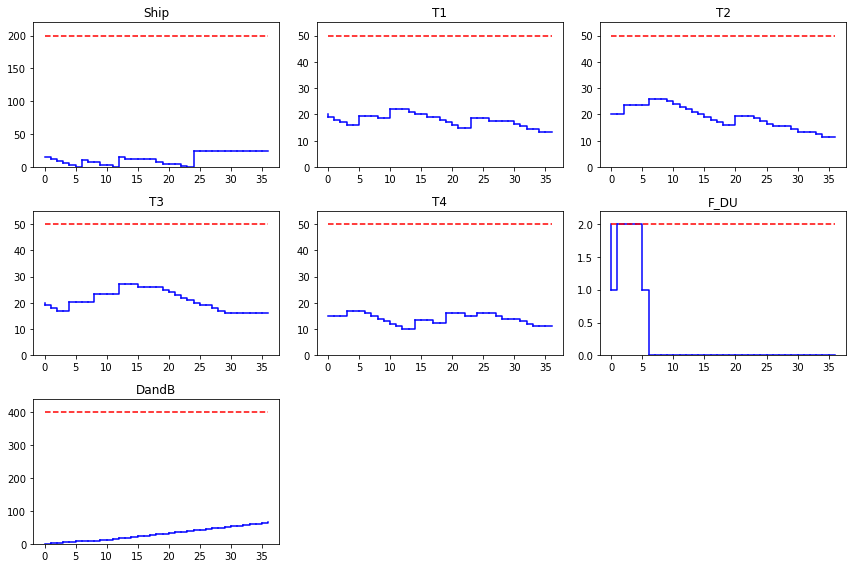

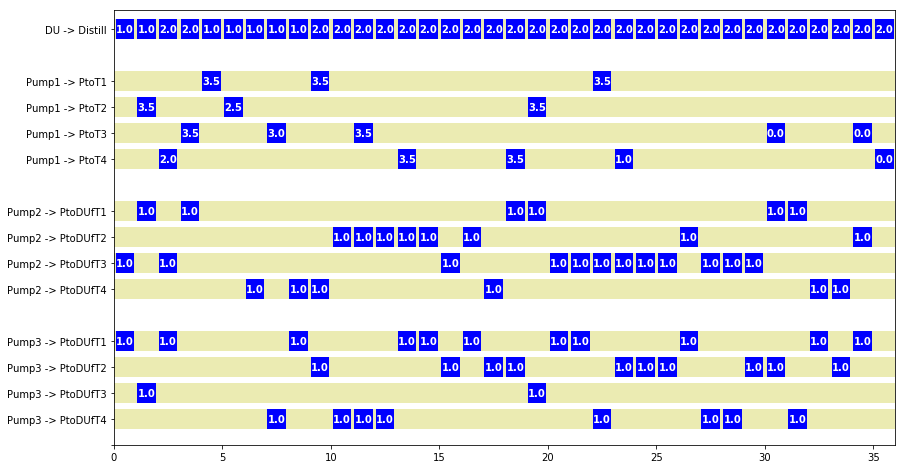

In [5]:
baseline = Kondili
oilprob(baseline)

### Baseline Analysis:

Profit is \$40,190,612. Notice that all four tanks were made use of and the distillation column did not distill at its maximum rate of 2,000 $m^3/hr$ at times 2 through 8, resulting in a total of 65,000 $m^3$ product produced. We will now explore how investing in pumps capable of higher flowrates can influence profits.

<a id='P1'></a>
## 5. Pump 1 Flowrate Capacity
[Link to Table of Contents](#TC)

This analysis looks at three different pumps with increasing maximum flowrate from 4,500 $m^3$ to 6000 $m^3$. This analysis compares the profit and allocation of resources as compared to the initial baseline.

### 4,500 $m^3/hr$ Scenario

Total crude distilled    =    69,000.00 m^3
Value of State Inventories = $59,746,900.67
  Cost of Unit Assignments = $16,096,300.00
             Net Objective = $43,650,600.67


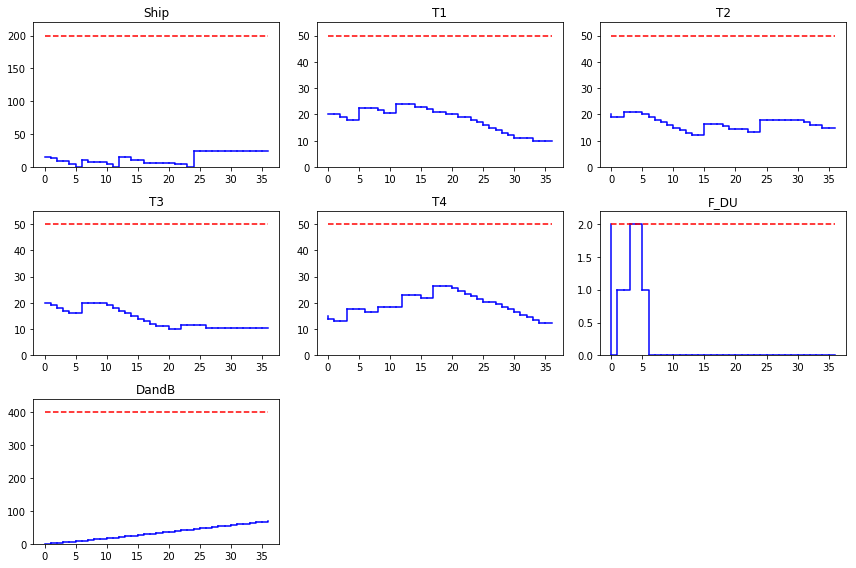

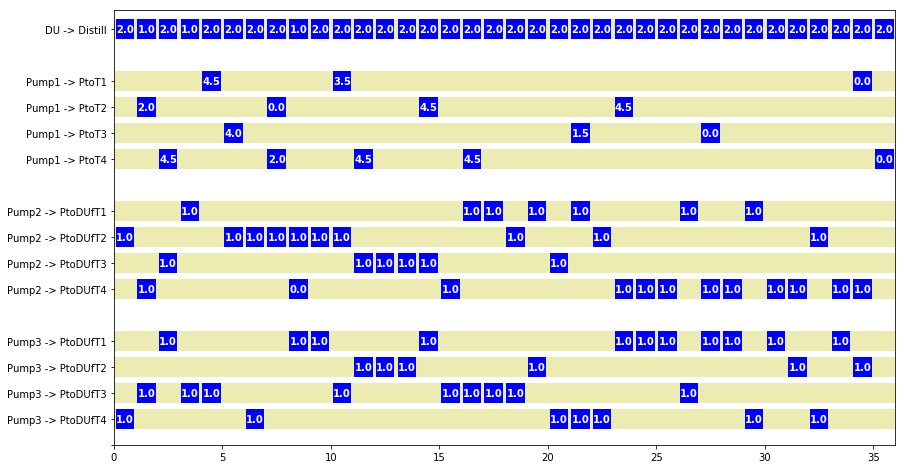

In [6]:
vpump1new= 4.5
Kondili['UNIT_TASKS'][('Pump1','PtoT1')]['Bmax']=vpump1new
Kondili['UNIT_TASKS'][('Pump1','PtoT2')]['Bmax']=vpump1new
Kondili['UNIT_TASKS'][('Pump1','PtoT3')]['Bmax']=vpump1new
Kondili['UNIT_TASKS'][('Pump1','PtoT4')]['Bmax']=vpump1new
oilprob(Kondili)

### 5000 $m^3/hr$ Scenario

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $16,099,000.00
             Net Objective = $46,245,592.00


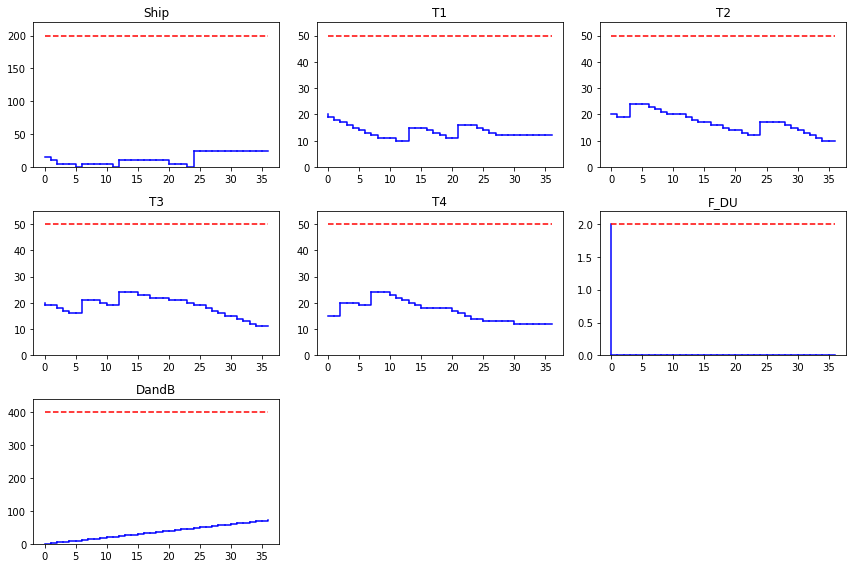

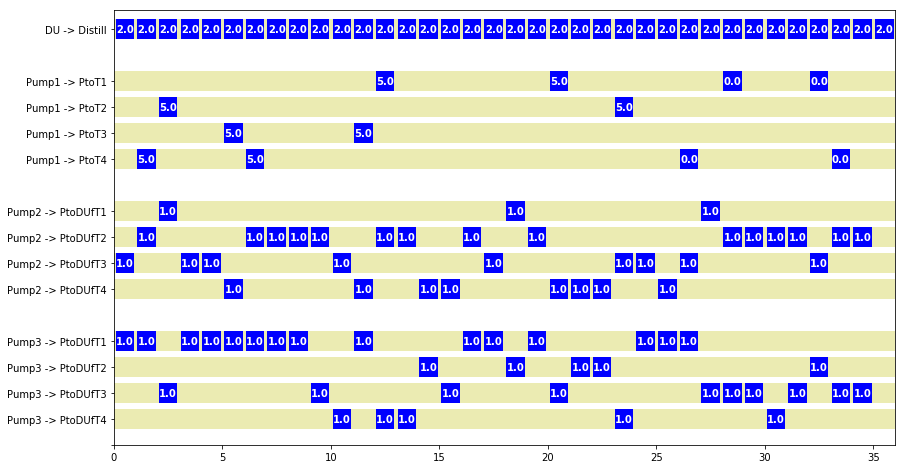

In [7]:
vpump1new2= 5
Kondili['UNIT_TASKS'][('Pump1','PtoT1')]['Bmax']=vpump1new2
Kondili['UNIT_TASKS'][('Pump1','PtoT2')]['Bmax']=vpump1new2
Kondili['UNIT_TASKS'][('Pump1','PtoT3')]['Bmax']=vpump1new2
Kondili['UNIT_TASKS'][('Pump1','PtoT4')]['Bmax']=vpump1new2
oilprob(Kondili)

### 6000 $m^3/hr$ Scenario

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $16,099,000.00
             Net Objective = $46,245,592.00


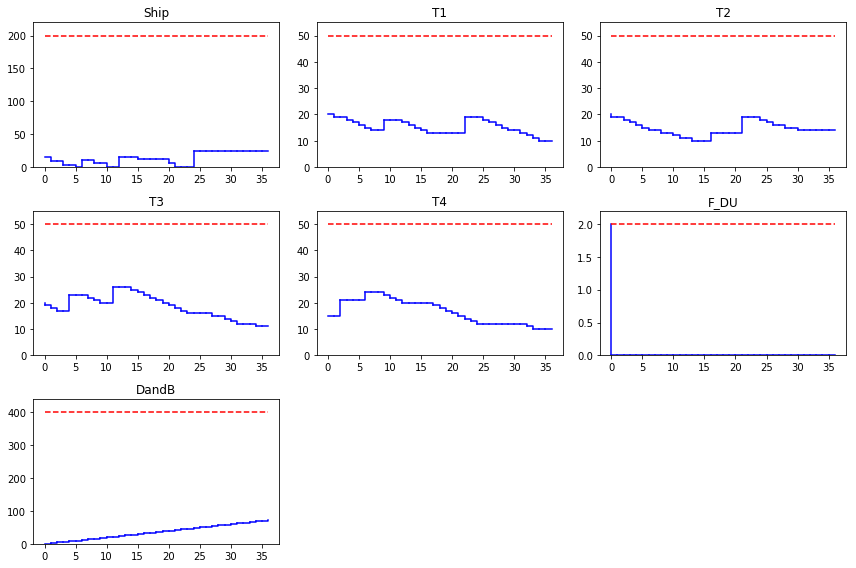

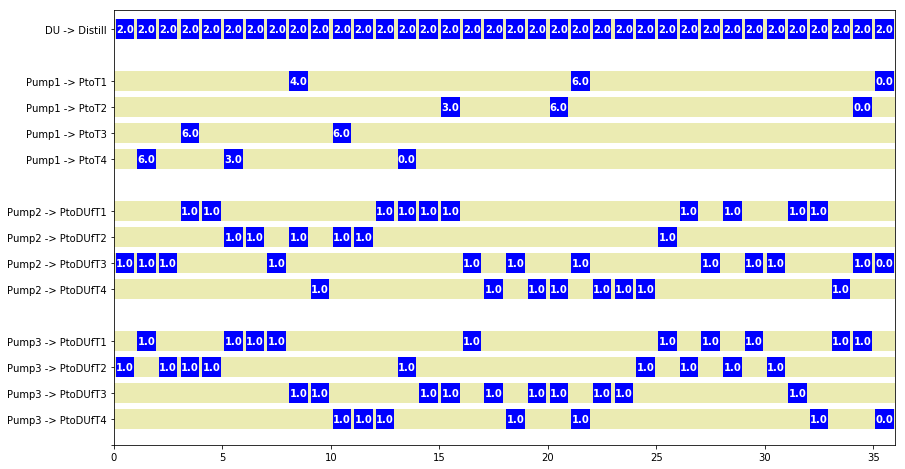

In [8]:
vpump1new3= 6
Kondili['UNIT_TASKS'][('Pump1','PtoT1')]['Bmax']=vpump1new3
Kondili['UNIT_TASKS'][('Pump1','PtoT2')]['Bmax']=vpump1new3
Kondili['UNIT_TASKS'][('Pump1','PtoT3')]['Bmax']=vpump1new3
Kondili['UNIT_TASKS'][('Pump1','PtoT4')]['Bmax']=vpump1new3
oilprob(Kondili)

### Pump 1 Flowrate Analysis

The 4,500 $m^3/hr$ flowrate pump increased the profit of the system by increasing the total amount of crude that was distilled from 65,000$m^3$ to 69,000$m^3$. This increased the profit of the operation by \$3,463,587 to \$59,746,900. The 5000 $m^3/hr$ pump increased the production of the operation from the baseline by 7,000 $m^3$ to the maximum distillation procduction possible of 72,000 $m^3$. This added production increased the profit by \$6,061,592 to \$62,344,592. The final pump at 6,000 $m^3/hr$ had no increase in production or profit as compared to the 5,000 $m^3/hr$ pump so the 5,000 $m^3/hr$ pump was proven to be the maximum flowrate needed for pump 1. This pump will be used for further analysis and is initialized in the following code cell. Note that all pumps utilized all four tanks, which shows that this pump cannot soley allow the use of three or less tanks.

In [9]:
Kondili['UNIT_TASKS'][('Pump1','PtoT1')]['Bmax']=vpump1new2
Kondili['UNIT_TASKS'][('Pump1','PtoT2')]['Bmax']=vpump1new2
Kondili['UNIT_TASKS'][('Pump1','PtoT3')]['Bmax']=vpump1new2
Kondili['UNIT_TASKS'][('Pump1','PtoT4')]['Bmax']=vpump1new2

<a id='P23'></a>
## 6. Pump 2 and 3 Flowrate Capacity
[Link to Table of Contents](#TC)

Having found 5000 $m^3/hr$ to be the optimal Pump 1 flowrate capacity, we move to analysis of the flowrate capacities of Pump 2 and Pump 3. We move from the baseline of 1000 $m^3/hr$ to 1200, 1500, and 2000 $m^3/hr$.

### 1,200 $m^3/hr$ Scenario

Total crude distilled    =    70,000.00 m^3
Value of State Inventories = $60,612,797.78
  Cost of Unit Assignments = $12,099,900.00
             Net Objective = $48,512,897.78


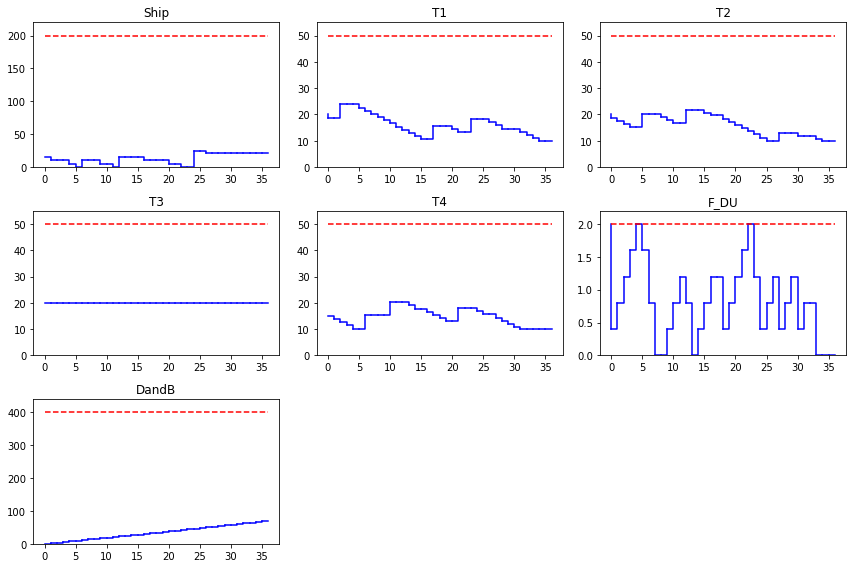

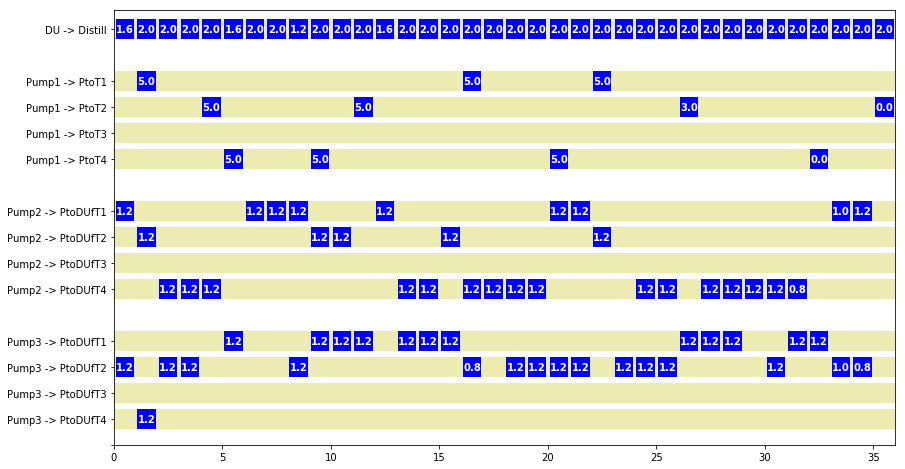

In [10]:
vpump2new = 1.2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT1')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT2')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT3')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT4')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT1')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT2')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT3')]['Bmax']=vpump2new
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT4')]['Bmax']=vpump2new
oilprob(Kondili)

### 1500 $m^3/hr$ Scenario

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $12,099,000.00
             Net Objective = $50,245,592.00


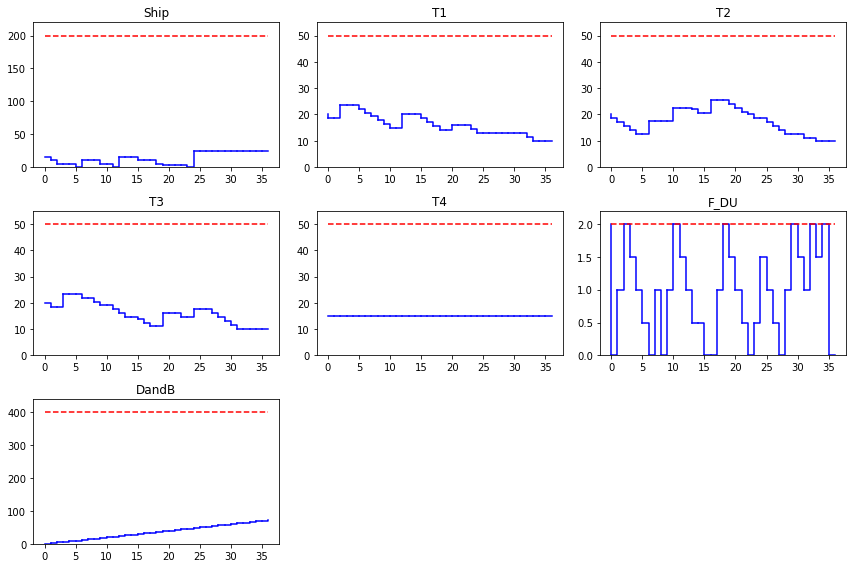

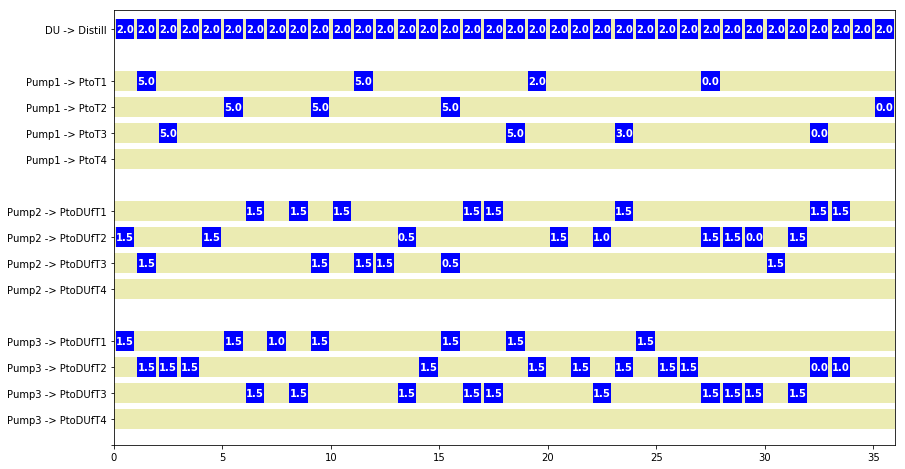

In [11]:
vpump2new2 = 1.5
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT1')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT2')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT3')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT4')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT1')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT2')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT3')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT4')]['Bmax']=vpump2new2
oilprob(Kondili)

### 2000 $m^3/hr$ Scenario

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $12,099,000.00
             Net Objective = $50,245,592.00


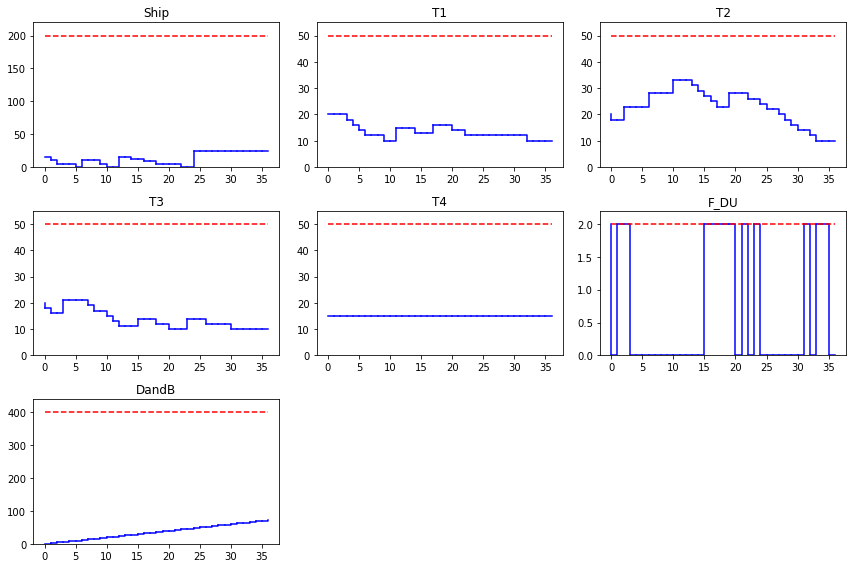

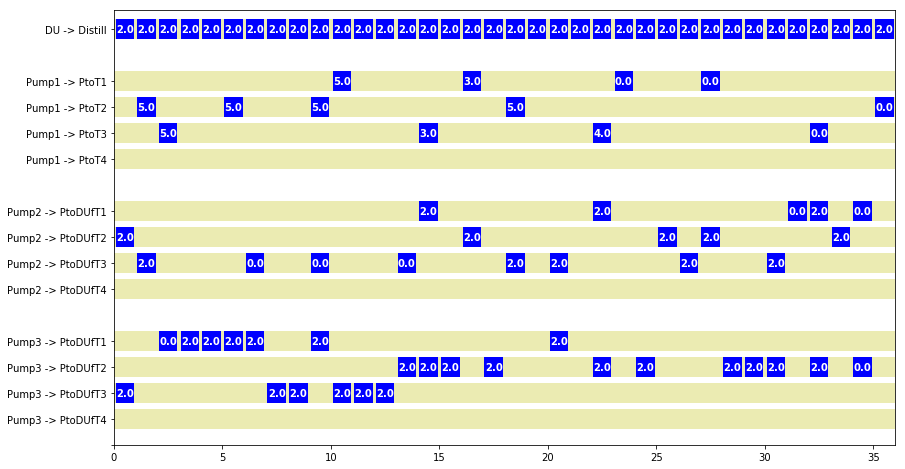

In [12]:
vpump2new3 = 2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT1')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT2')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT3')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT4')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT1')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT2')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT3')]['Bmax']=vpump2new3
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT4')]['Bmax']=vpump2new3
oilprob(Kondili)

### Pump 2 and 3 Flowrate Capacity Analysis

There is a jump in profit until flowrates of 1500 $m^3/hr$ are attained for each of the pumps. The added profit from previous conditions (baseline but with Pump 1 flow rate of 5000 $m^3/hr$) is \$4,000,000.

This is due to the use of only 3 tanks. The maximum amount of crude, 72,000 $m^3$, is still distilled during the horizon. The entire change in profit is due to the usage of 1 less tank. The flow rate of 1500 $m^3/hr$ is set below for both Pump1 and Pump2 and used in the next analyses.

In [13]:
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT1')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT2')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT3')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump2','PtoDUfT4')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT1')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT2')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT3')]['Bmax']=vpump2new2
Kondili['UNIT_TASKS'][('Pump3','PtoDUfT4')]['Bmax']=vpump2new2

<a id='ST'></a>
## 7. Settling Time
[Link to Table of Contents](#TC)

This analysis will investigate the effect of settling time on profit and allocation of resources on the system. This will simulate the purchasing or development of a better desalting process.

### Settling Time of 2 Hours

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $12,099,000.00
             Net Objective = $50,245,592.00


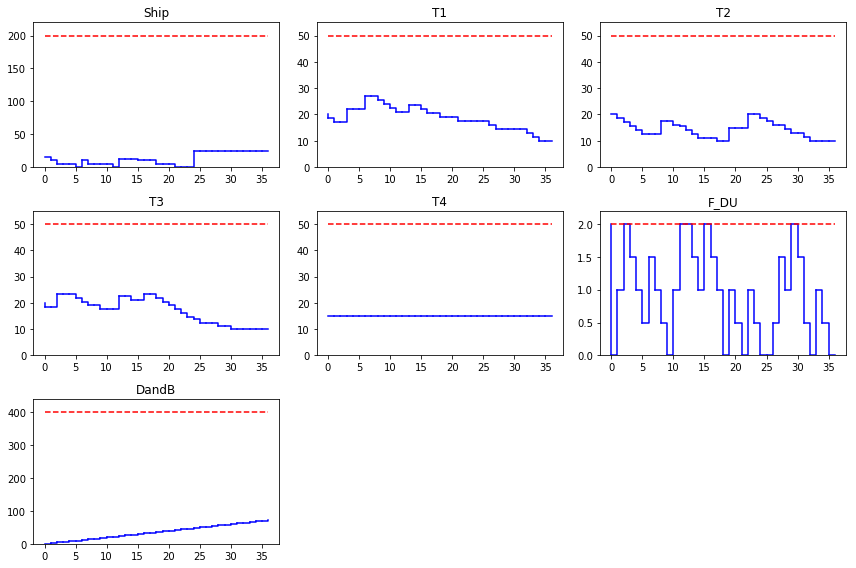

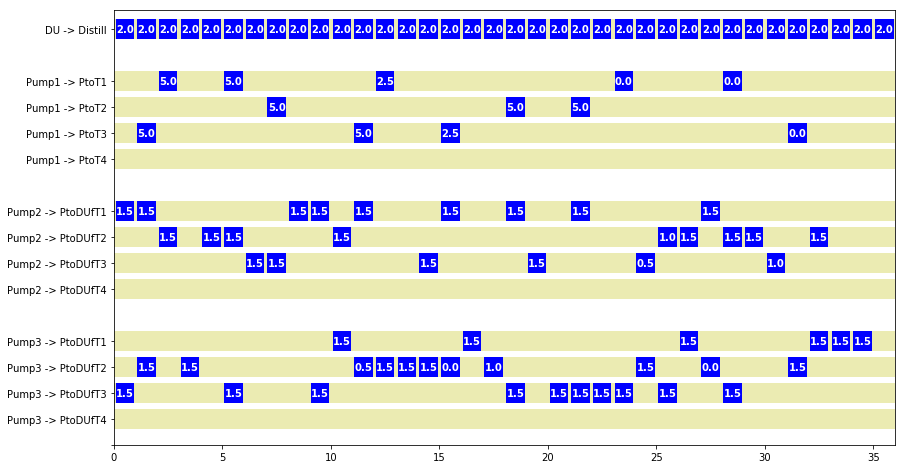

In [14]:
tsettle = 2
oilprob(Kondili)

### Settling Time of One Hour

Total crude distilled    =    70,000.00 m^3
Value of State Inventories = $60,612,797.78
  Cost of Unit Assignments = $8,104,400.00
             Net Objective = $52,508,397.78


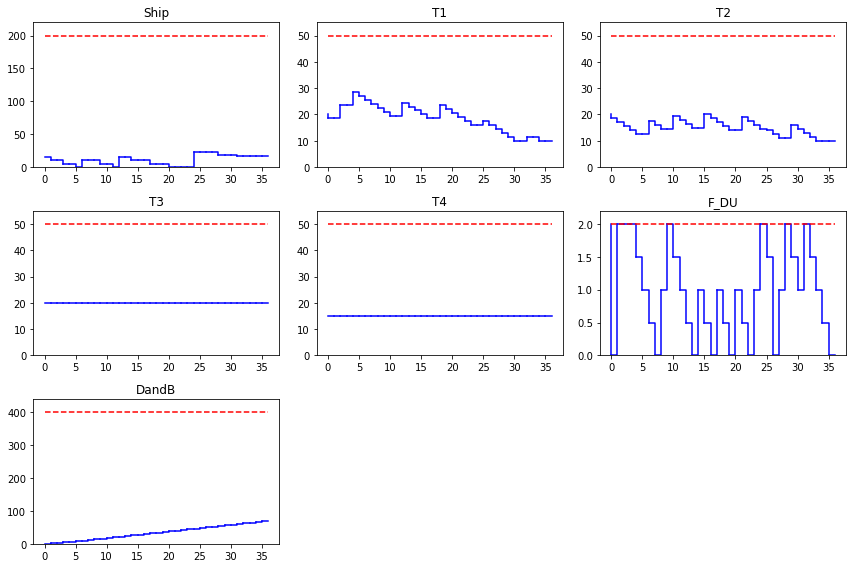

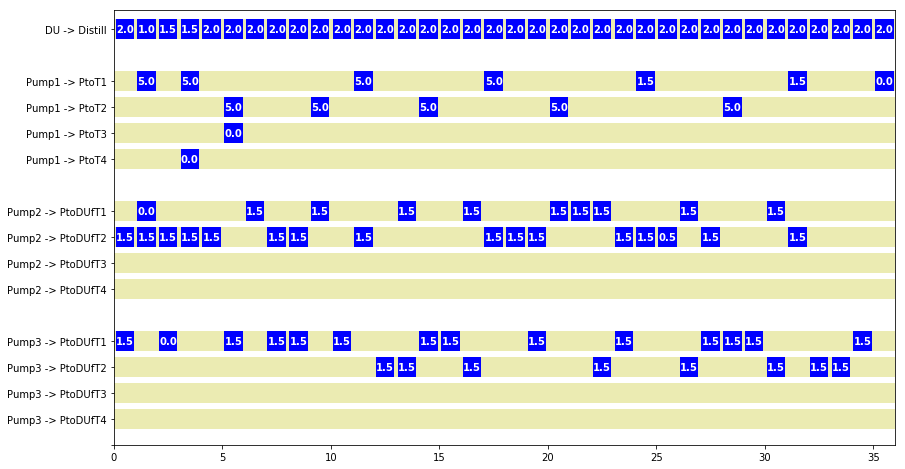

In [15]:
tsettle = 1
oilprob(Kondili)

### No Settling Time

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $8,108,000.00
             Net Objective = $54,236,592.00


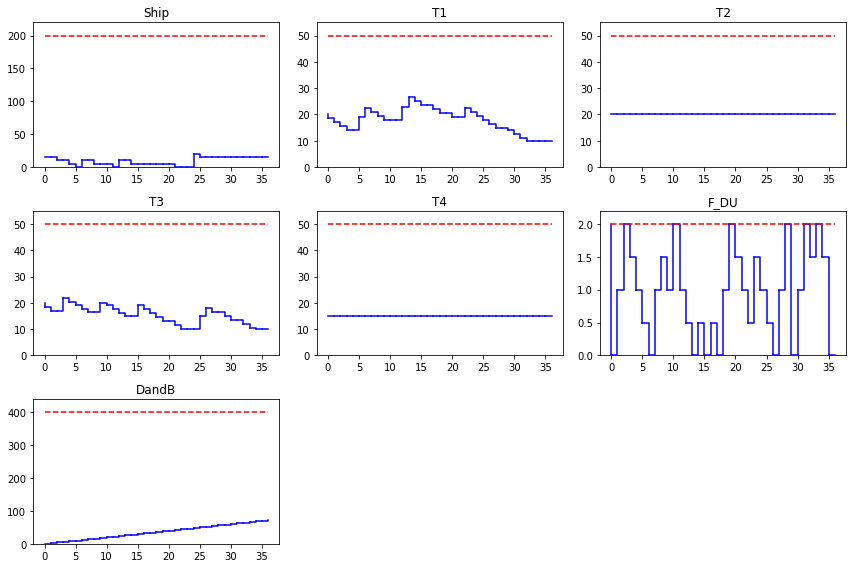

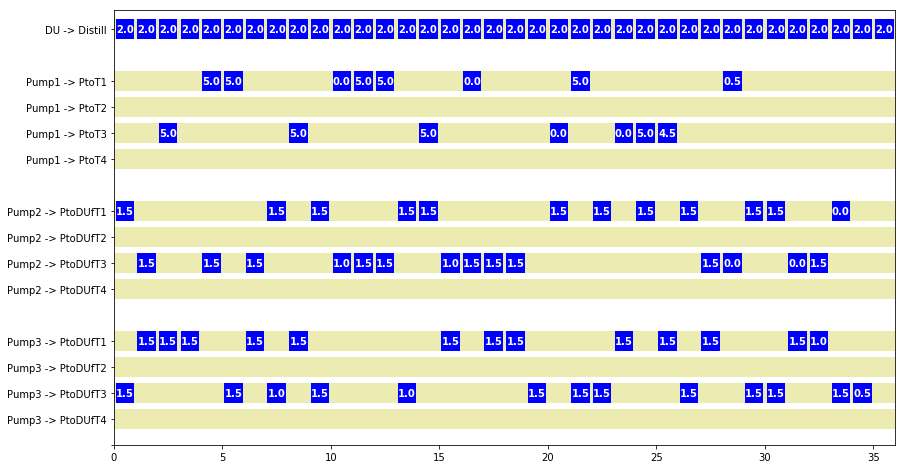

In [16]:
tsettle = 0
oilprob(Kondili)

### Settling Time Analysis
When the settling time was decreased from 3 hours to 2 hours there was no effect on the profit or allocation of the resources. The system was still required to use three tanks, which was a large portion of the cost. The maximum production was still reached in this system. When the settling time was lowered to 1 hour, there was an increase in profit of \$2,262,805 from the three hour settling time. This was mostly due to the cost reduction from the use of only two tanks. With this settling time, the maximum distillation was not reached, falling short at 70,000 $m^3$. When the settleing time was reduced even further so that there was no settling time such that once the pump has stopped adding oil,  oil could be removed and sent to the distillation column, the maximum production was available in the two tank system. This was the most profitable setup with a \$3,991,000 increase in profit from the three tank system. 

<a id='CTU'></a>
## 8. Cost of Tank Use
[Link to Table of Contents](#TC)  

This analysis will look at the effect of the cost of using the tanks on the allocation of resources.

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $   99,003.00
             Net Objective = $62,245,589.00
Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $5,299,497.00
             Net Objective = $57,045,095.00


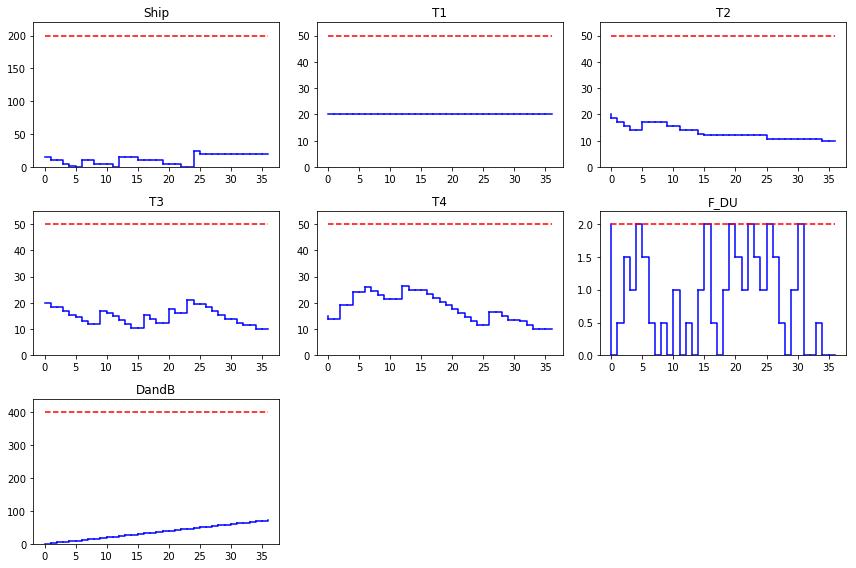

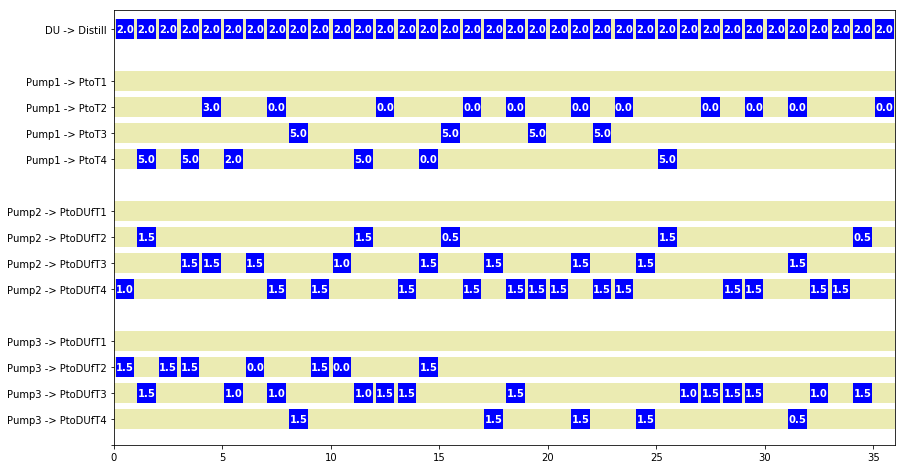

In [17]:
tsettle =3 
tankcost = 1
oilprob(Kondili)
tsettle =1 
tankcost = 1731999
oilprob(Kondili)

Total crude distilled    =    72,000.00 m^3
Value of State Inventories = $62,344,592.00
  Cost of Unit Assignments = $5,294,379.67
             Net Objective = $57,050,212.33


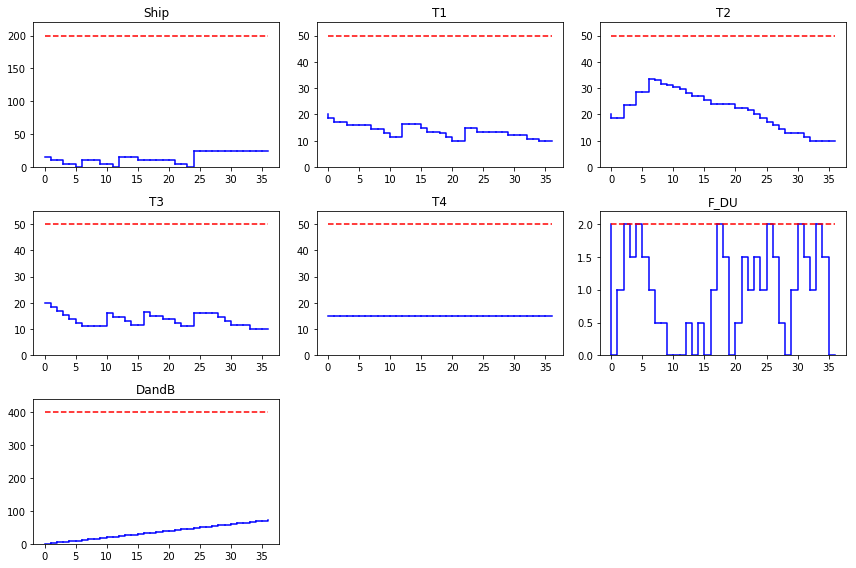

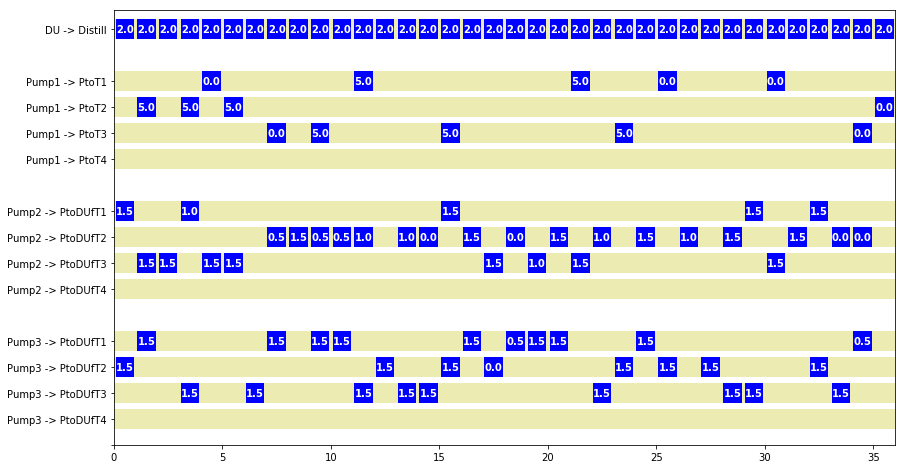

In [18]:
tsettle =1 
tankcost = 2*pdcrude-1
oilprob(Kondili)

### Cost of Tank Use Analysis
Even at the very small cost of \$1 for an additional tank, in the three hour settle time regime the fourth tank was not utilized. This was due to there being no additional value to extract from distillation as the operation was producing at the maximum production. In the one hour settling time regime, three tanks were utilized until the price of utilizing the additional tank exceeds the value of the 2,000 $m^3$ of products which would be lost. The cost just below the regime changeover point is shown in the second scenario.

<a id='Conclusion'></a>
## 9. Conclusion

[Link to Table of Contents](#TC) 

This Pyomo model can be used to analyze the effects of various operating constraints and conditions on refinery profit. As has been shown, factors like pump flowrate and brine settling time can be altered in order to determine the added profit available from unit upgrades. As a result, management can make well-informed decisions in purchasing new or improved equipment at the refinery.

Additionally, this model could be utilized on an ongoing basis, being solved every minute as oil tanker schedules change in order to determine the optimum allocation of resources for the next 1.5 day time horizon.

Finally, further work could go into developing this model to allow it to handle additional operational constraints. An important addition would be the model's ability to handle input of different types of crude and calculate the fraction of crude in each unit and state during the time horizon. While such constraints are nonlinear, McCormick envelopes could be utilized for the development of bilinear terms. An adaptation of this model which includes constraints which allow for the calculation of the mole fraction of two crude types is included in the Appendix below.

<a id='References'></a>
## 10. References

[Link to Table of Contents](#TC) 

Joly, M., Moro, L. F. L., & Pinto, J. M. (2002). Planning and Scheduling for Petroleum Refineries Using Mathematical Programming. Brazilian Journal of Chemical Engineering, 19(2), 207-228.

Kantor, J. C. (2017). Scheduling Multipurpose Batch Processes Using State-Task Networks. https://github.com/jckantor/CBE40455/blob/master/notebooks/Scheduling%20Multipurpose%20Batch%20Processes%20using%20State-Task%20Networks.ipynb 

Kondili, E., Pantelides, C. C., & Sargent, R. W. H. (1993). A General Algorithm for Short-Term Scheduling of Batch Operations—I. MILP Formulation. Computers & Chemical Engineering, 17(2), 211-227.

Moro, L. F. L, Pinto, J. M (2004). Mixed-Integer Programming Approach for Short-Term Crude Oil Scheduling. Ind. Eng. Chem. Res., 43(1), 85-94

<a id='APDX'></a>

## Appendix: Utilizing McCormick Envelope

[Link to Table of Contents](#TC)

This Appendix adds McCormick bilinear constraints to the model outlined in this report. These constraints arise from the added complication of dealing with two types of crude - regular and Marlin. Marlin crude is viscous and as a result the distillation tower cannot operate with crude of a Marlin fraction above 0.5. Such bilinear constraints are necessary because the following nonlinear constraints must be added in order for the model to abide by limitations in mole fraction:

$$ SM_{s,t} = S_{s,t}*MF_s $$  
$$ QM_{j,t} = Q_{j,t}*MF_j $$  
$$ BM_{ijt} = B_{ijt}*MF_s $$

where S, Q, and B are as described previously, SM, QM, and BM are the amount of Marlin in a state, unit, and beginning a task, and $MF_s$ and $MF_j$ are the mole fraction of Marlin in a state and unit.

Each of these three constraints requires four bilinear constraints (for an explanation, see https://optimization.mccormick.northwestern.edu/index.php/McCormick_envelopes). These constraints are included in the model below, along with added features included in the STN set-up due to the need to initialize Marlin conditions. Included in the bilinear constraints are bounds in $S$, $MF_s$, $MF_j$, $Q$, and $B$. More work needs to be done in order to determine tight bounds for these added constraints to be effective.

### Set-Up STN

In [19]:
H = 12 # hours

con = 0 # cost to turn pump on
cvar = 0.9*1000 # cost for each m^3 pumped 
# from https://www.engineeringtoolbox.com/water-pumping-costs-d_1527.html
# with assumption pumping crude is roughly 10 times as costly as pumping water
# due to viscosity differences

tankcost = 4e6 # savings possible assuming $1,000,000 annual savings
# for each tank not used

tpump = 1 # hrs to pump 2000 m^3 for pumps 2,3 and 5000 m^3 for pump 1
tstill = 1 # hrs to distill 2000 m^3

tsettle = 1 # hrs required for brine to settle in crude before it can be sent to the distillation unit (DU)

shiploads = {6:[10,2],
            12:[15,4],
            24:[25,]}# key:value is time:[amount of crude shipment,amount of Marlin in crude shipment]

pdcrude = ((20/36)*2.5+(12/36)*3+(4/36)*8)*(264.172)*1000
# https://www.eia.gov/energyexplained/index.cfm?page=oil_refining

# all amounts are in thousands, all costs/prices are in USD
Kondili = {
    'TIME':  range(0,H+1),
    'STATES': {
        'Ship'     : {'capacity': 200  , 'minimum': 0 ,'initial': 15,'initialM': 3,'MFsL': 0.1, 'MFsU': 0.7, 'price':  0},
        'T1'       : {'capacity': 50   , 'minimum': 10,'initial': 15,'initialM': 3,'MFsL': 0.005, 'MFsU': 0.7,'price':  0},
        'T2'       : {'capacity': 50   , 'minimum': 10,'initial': 15,'initialM': 3,'MFsL': 0.005, 'MFsU': 0.7,'price':  0},
        'T3'       : {'capacity': 50   , 'minimum': 10,'initial': 20,'initialM': 3,'MFsL': 0.005, 'MFsU': 0.7, 'price':  0},
        'T4'       : {'capacity': 50   , 'minimum': 10,'initial': 15,'initialM': 3,'MFsL': 0.005, 'MFsU': 0.7, 'price':  0},
        'F_DU'     : {'capacity': 2    , 'minimum': 0 ,'initial': 2 ,'initialM': 0,'MFsL': 0.0, 'MFsU': 1, 'price':  0},
        'DandB'    : {'capacity': 400  , 'minimum': 0 ,'initial': 0 ,'initialM': 0,'MFsL': 0.0, 'MFsU': 1, 'price':  pdcrude}
    },
    'UNITS_BL': { # information needed for bilinear constraints relating to the units
        'Pump1': {'Qmax': 5, 'Qmin': 0, 'MFjL': 0, 'MFjU': 1},
        'Pump2': {'Qmax': 2, 'Qmin': 0, 'MFjL': 0, 'MFjU': 1},
        'Pump3': {'Qmax': 2, 'Qmin': 0, 'MFjL': 0, 'MFjU': 1},
        'DU'   : {'Qmax': 2, 'Qmin': 1, 'MFjL': 0, 'MFjU': 0.5},
    },
    'ST_ARCS': {
        ('Ship'  ,   'PtoT1')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT2')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT3')     : {'rho': 1.0},
        ('Ship'  ,   'PtoT4')     : {'rho': 1.0},
        ('T1'    ,   'PtoDUfT1')  : {'rho': 1.0},
        ('T2'    ,   'PtoDUfT2')  : {'rho': 1.0},
        ('T3'    ,   'PtoDUfT3')  : {'rho': 1.0},
        ('T4'    ,   'PtoDUfT4')  : {'rho': 1.0},
        ('F_DU'  ,   'Distill')   : {'rho': 1.0}
    },
    'TS_ARCS': {
        ('PtoT1'     , 'T1')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT2'     , 'T2')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT3'     , 'T3')       : {'dur': tpump , 'rho': 1.0},
        ('PtoT4'     , 'T4')       : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT1'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT2'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT3'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('PtoDUfT4'  , 'F_DU')     : {'dur': tpump , 'rho': 1.0},
        ('Distill'   , 'DandB')    : {'dur': tstill, 'rho': 1.0}
    },
    'UNIT_TASKS': {
        ('Pump1'    , 'PtoT1')     : {'Bmin': 0, 'Bmax': 5, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT2')     : {'Bmin': 0, 'Bmax': 5, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT3')     : {'Bmin': 0, 'Bmax': 5, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump1'    , 'PtoT4')     : {'Bmin': 0, 'Bmax': 5, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT1')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT1')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT2')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT2')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT3')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT3')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump2'    , 'PtoDUfT4')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('Pump3'    , 'PtoDUfT4')  : {'Bmin': 0, 'Bmax': 2, 'Cost': con, 'vCost': cvar, 'Tclean': 0},
        ('DU'       , 'Distill')   : {'Bmin': 1, 'Bmax': 2, 'Cost': 0  , 'vCost': 0   , 'Tclean': 0}
    },
}

### Characterization of Tasks, States, and Units

In [20]:
STN = Kondili

STATES = STN['STATES']
TANKS = ['T1','T2','T3','T4']
ST_ARCS = STN['ST_ARCS']
TS_ARCS = STN['TS_ARCS']
UNIT_TASKS = STN['UNIT_TASKS']
UNITS_BL = STN['UNITS_BL']
TIME = STN['TIME']
H = max(TIME)

TASKS = set([i for (j,i) in UNIT_TASKS])                         # set of all tasks 

S = {i: set() for i in TASKS}                                    # S[i] input set of states which feed task i
for (s,i) in ST_ARCS:
    S[i].add(s)

S_ = {i: set() for i in TASKS}                                   # S_[i] output set of states fed by task i
for (i,s) in TS_ARCS:
    S_[i].add(s)

rho = {(i,s): ST_ARCS[(s,i)]['rho'] for (s,i) in ST_ARCS}        # rho[(i,s)] input fraction of task i from state s

rho_ = {(i,s): TS_ARCS[(i,s)]['rho'] for (i,s) in TS_ARCS}       # rho_[(i,s)] output fraction of task i to state s

P = {(i,s): TS_ARCS[(i,s)]['dur'] for (i,s) in TS_ARCS}          # P[(i,s)] time for task i output to state s   

p = {i: max([P[(i,s)] for s in S_[i]]) for i in TASKS}           # p[i] completion time for task i

K = {i: set() for i in TASKS}                                    # K[i] set of units capable of task i
for (j,i) in UNIT_TASKS:
    K[i].add(j) 

T = {s: set() for s in STATES}                                   # T[s] set of tasks receiving material from state s 
for (s,i) in ST_ARCS:
    T[s].add(i)

T_ = {s: set() for s in STATES}                                  # set of tasks producing material for state s
for (i,s) in TS_ARCS:
    T_[s].add(i)

C  = {s: STATES[s]['capacity'] for s in STATES}                   # C[s] storage capacity for state s
MV = {s: STATES[s]['minimum'] for s in STATES}                    # MV[s] minimum volume allowed in state s
MFsU = {s: STATES[s]['MFsU'] for s in STATES}
MFsL = {s: STATES[s]['MFsL'] for s in STATES}
SU = {s: STATES[s]['capacity'] for s in STATES}
SL = {s: STATES[s]['minimum'] for s in STATES}

UNITS = set([j for (j,i) in UNIT_TASKS])

I = {j: set() for j in UNITS}                                     # I[j] set of tasks performed with unit j
for (j,i) in UNIT_TASKS:
    I[j].add(i)

Bmax = {(i,j):UNIT_TASKS[(j,i)]['Bmax'] for (j,i) in UNIT_TASKS}  # Bmax[(i,j)] maximum capacity of unit j for task i
Bmin = {(i,j):UNIT_TASKS[(j,i)]['Bmin'] for (j,i) in UNIT_TASKS}  # Bmin[(i,j)] minimum capacity of unit j for task i
QU = {j:UNITS_BL[j]['Qmax'] for j in UNITS}
QL = {j:UNITS_BL[j]['Qmin'] for j in UNITS}
MFjL = {j:UNITS_BL[j]['MFjL'] for j in UNITS}
MFjU = {j:UNITS_BL[j]['MFjU'] for j in UNITS}

### Pyomo Model

In [21]:
from pyomo.environ import *
import numpy as np

TIME = np.array(TIME)

model = ConcreteModel()

model.W = Var(TASKS, UNITS, TIME, domain=Boolean)             # W[i,j,t] 1 if task i starts in unit j at time t
model.B = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)    # B[i,j,t,] size of batch assigned to task i in unit j at time t
model.BM = Var(TASKS, UNITS, TIME, domain=NonNegativeReals)
model.S = Var(STATES.keys(), TIME, domain=NonNegativeReals)   # S[s,t] inventory of state s at time t
model.SM = Var(STATES.keys(), TIME, domain=NonNegativeReals)
model.MFs = Var(STATES.keys(), TIME, domain=NonNegativeReals)
model.Q = Var(UNITS, TIME, domain=NonNegativeReals)           # Q[j,t] inventory of unit j at time t
model.QM = Var(UNITS, TIME, domain=NonNegativeReals)
model.MFj = Var(UNITS, TIME, domain=NonNegativeReals)
model.TOO = Var(TANKS, domain=Boolean)                        # TOO[s in TANKS] boolean: if 1, tank was used, if 0, tank was not used
model.Cost = Var(domain=NonNegativeReals)
model.Value = Var(domain=NonNegativeReals)

# Objective is to maximize the value of the final state (see Kondili, Sec. 5)
model.Obj = Objective(expr = model.Value - model.Cost, sense = maximize)

# Constraints
model.cons = ConstraintList()
model.cons.add(model.Value == sum([STATES[s]['price']*model.S[s,H] for s in STATES]))
model.cons.add(model.Cost == sum([UNIT_TASKS[(j,i)]['Cost']*model.W[i,j,t] +
        UNIT_TASKS[(j,i)]['vCost']*model.B[i,j,t] for i in TASKS for j in K[i] for t in TIME])+ 
               sum([model.TOO[tk]*tankcost for tk in TANKS])) 

# unit constraints
for j in UNITS:
    rhs = 0
    rhsM = 0 # marlin
    for t in TIME:
        # a unit can only be allocated to one task 
        lhs = 0
        for i in I[j]:
            for tprime in TIME:
                if tprime >= (t-p[i]+1-UNIT_TASKS[(j,i)]['Tclean']) and tprime <= t:
                    lhs += model.W[i,j,tprime]
        model.cons.add(lhs <= 1)

        # capacity constraints (see Kondili, Sec. 3.1.2)
        for i in I[j]:
            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.B[i,j,t])
            model.cons.add(model.B[i,j,t] <= model.W[i,j,t]*Bmax[i,j])
#            model.cons.add(model.W[i,j,t]*Bmin[i,j] <= model.BM[i,j,t])
#            model.cons.add(model.BM[i,j,t] <= model.W[i,j,t]*Bmax[i,j])

        # unit mass balance
        rhs += sum([model.B[i,j,t] for i in I[j]])
        rhsM += sum([model.BM[i,j,t] for i in I[j]])
        for i in I[j]:
            for s in S_[i]:
                if t >= P[(i,s)]:
                    rhs -= rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
                    rhsM -= rho_[(i,s)]*model.BM[i,j,max(TIME[TIME <= t-P[(i,s)]])] 
        model.cons.add(model.Q[j,t] == rhs)
        model.cons.add(model.QM[j,t] == rhsM)
        rhs = model.Q[j,t]
        rhsM = model.QM[j,t]
        

# state mass balance constraints
for s in STATES.keys():
    rhs = STATES[s]['initial']
    rhsM = STATES[s]['initialM']
    for t in TIME:
        # state capacity constraint
        model.cons.add(model.S[s,t] <= C[s])
        model.cons.add(model.S[s,t] >= MV[s])
        
        # accounting for shipload schedule
        if t in shiploads.keys() and s == 'Ship':
            rhs += shiploads[t][0]
            rhsM += shiploads[t][1]
            
        # state mass balanaces
        for i in T_[s]:
            for j in K[i]:
                if t >= P[(i,s)]: 
                    rhs += rho_[(i,s)]*model.B[i,j,max(TIME[TIME <= t-P[(i,s)]])]
                    rhsM += rho_[(i,s)]*model.BM[i,j,max(TIME[TIME <= t-P[(i,s)]])]
        for i in T[s]:
            rhs -= rho[(i,s)]*sum([model.B[i,j,t] for j in K[i]])
            rhsM -= rho[(i,s)]*sum([model.BM[i,j,t] for j in K[i]])
                                                                 
        model.cons.add(model.S[s,t] == rhs)
        model.cons.add(model.SM[s,t] == rhsM)
        rhs = model.S[s,t]
        rhsM = model.SM[s,t]
        
        # require previous ship to have emptied crude before next comes
        if t in shiploads.keys() and s == 'Ship':
            model.cons.add(model.S[s,t-1] == 0)
            model.cons.add(model.SM[s,t-1] == 0)

# tank brine settling time constraint, tank cost constraint
for tk in TANKS:
    Wsumforcost = 0 # sum of decision variables to see if a tank was used over the time period
    for t in TIME:
        Wsums = 0 # sum of decision variables to determine if settling has completed
        for i in T[tk]:
            for j in K[i]:
                Wsums += model.W[i,j,t] # add decision variables for pumping away from tank
                Wsumforcost += model.W[i,j,t] # add decision variables for pumping away from tank
                
        for i in T_[tk]:
            for j in K[i]:
                for ts in range(0,tsettle+1):
                    Wsums += model.W[i,j,t-min(t,ts)] # add decision variables for sending material to tank within tsettle
        model.cons.add(Wsums <= 1)
        
        for i in T_[tk]:
            for j in K[i]:
                Wsumforcost += model.W[i,j,t]
        
    model.cons.add(Wsumforcost == Wsumforcost*model.TOO[tk]) # tank cost constraint: if any crude is pumped away from tank, boolean TOO is turned on
    

# Distillation unit can never shut down (this is very costly)
for t in TIME[:-1]:
    model.cons.add(model.W['Distill','DU',t] == 1)
    
# Ditillation unit has a maxium volme of 2000m^3
for t in TIME:
    model.cons.add(model.Q['DU',t] <= 2)
    
# McCormick Bilinear Constraints
# constraint QM = Q*MFj
for t in TIME:
    for j in UNITS:
        model.cons.add(model.QM[j,t] <= model.Q[j,t]*MFjL[j]+model.MFj[j,t]*QU[j]-MFjL[j]*QU[j])
        model.cons.add(model.QM[j,t] <= model.Q[j,t]*MFjU[j]+model.MFj[j,t]*QL[j]-MFjU[j]*QL[j])
        model.cons.add(model.QM[j,t] >= model.Q[j,t]*MFjU[j]+model.MFj[j,t]*QU[j]-MFjU[j]*QU[j])
        model.cons.add(model.QM[j,t] >= model.Q[j,t]*MFjL[j]+model.MFj[j,t]*QL[j]-MFjL[j]*QL[j])

for t in TIME:
    for s in STATES:
        # constraint SM = S*MFs
        model.cons.add(model.SM[s,t] <= model.S[s,t]*MFsL[s]+model.MFs[s,t]*SU[s]-MFsL[s]*SU[s])
        model.cons.add(model.SM[s,t] <= model.S[s,t]*MFsU[s]+model.MFs[s,t]*SL[s]-MFsU[s]*SL[s])
        model.cons.add(model.SM[s,t] >= model.S[s,t]*MFsU[s]+model.MFs[s,t]*SU[s]-MFsU[s]*SU[s])
        model.cons.add(model.SM[s,t] >= model.S[s,t]*MFsL[s]+model.MFs[s,t]*SL[s]-MFsL[s]*SL[s])
        for i in T[s]:
            for j in K[i]:
                # constraint BM = B*MFs
                model.cons.add(model.BM[i,j,t] <= model.B[i,j,t]*MFsL[s]+model.MFs[s,t]*Bmax[i,j]-MFsL[s]*Bmax[i,j])
                model.cons.add(model.BM[i,j,t] <= model.B[i,j,t]*MFsU[s]+model.MFs[s,t]*Bmin[i,j]-MFsU[s]*Bmin[i,j])
                model.cons.add(model.BM[i,j,t] >= model.B[i,j,t]*MFsU[s]+model.MFs[s,t]*Bmax[i,j]-MFsU[s]*Bmax[i,j])
                model.cons.add(model.BM[i,j,t] >= model.B[i,j,t]*MFsL[s]+model.MFs[s,t]*Bmin[i,j]-MFsL[s]*Bmin[i,j])

SolverFactory('gurobi').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1840
  Lower bound: 12738330.6667
  Upper bound: 12738330.6667
  Number of objectives: 1
  Number of constraints: 2194
  Number of variables: 943
  Number of binary variables: 173
  Number of integer variables: 173
  Number of continuous variables: 770
  Number of nonzeros: 6212
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was

In [22]:
print("Value of State Inventories = ${0:12,.2f}".format(model.Value()))
print("  Cost of Unit Assignments = ${0:12,.2f}".format(model.Cost()))
print("             Net Objective = ${0:12,.2f}".format(model.Value() - model.Cost()))

Value of State Inventories = $20,781,530.67
  Cost of Unit Assignments = $8,043,200.00
             Net Objective = $12,738,330.67


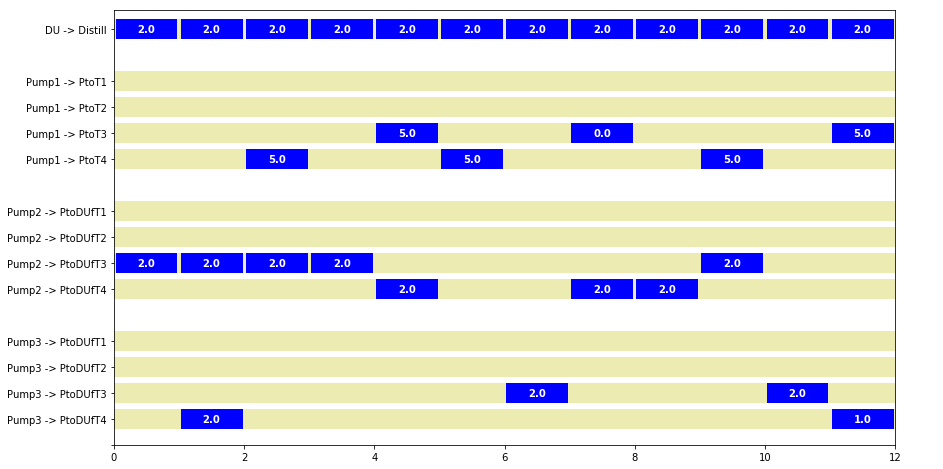

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

gap = H/500
idx = 1
lbls = []
ticks = []
for j in sorted(UNITS):
    idx -= 1
    for i in sorted(I[j]):
        idx -= 1
        ticks.append(idx)
        lbls.append("{0:s} -> {1:s}".format(j,i))
        plt.plot([0,H],[idx,idx],lw=20,alpha=.3,color='y')
        for t in TIME:
            if model.W[i,j,t]() > 0:
                plt.plot([t+gap,t+p[i]-gap], [idx,idx],'b', lw=20, solid_capstyle='butt')
                txt = "{0:.1f}".format(model.B[i,j,t]())
                plt.text(t+p[i]/2, idx, txt, color='white', weight='bold', ha='center', va='center')
idx -= 1
ticks.append(idx)
lbls.append('')
plt.xlim(0,H)
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(lbls);

In [24]:
print('QM[DU]','','Q[DU]', '', 'MFj[DU]','QM/Q[DU]' )
for t in TIME[:-1]:
    print('{:.3f},  {:.3f},  {:.12f}, {:.12f}'.format(model.QM['DU',t](),model.Q['DU',t](),model.MFj['DU',t](),
                                           model.QM['DU',t]()/model.Q['DU',t]()))

QM[DU]  Q[DU]  MFj[DU] QM/Q[DU]
0.000,  2.000,  0.000000000000, 0.000000000000
0.122,  2.000,  0.060769230769, 0.060769230769
0.134,  2.000,  0.066812130177, 0.066812130177
0.123,  2.000,  0.061686959490, 0.061686959490
0.282,  2.000,  0.140763873085, 0.140763873085
0.209,  2.000,  0.104579872752, 0.104579872752
0.209,  2.000,  0.104579872752, 0.104579872752
0.453,  2.000,  0.226591742220, 0.226591742220
0.205,  2.000,  0.102548369525, 0.102548369525
0.198,  2.000,  0.098796509159, 0.098796509158
0.095,  2.000,  0.047613796581, 0.047613796581
0.365,  2.000,  0.182557485754, 0.182557485754


In [25]:
print('SM[T3]','','S[T3]', ' ', 'MFs[T3]','SM/S[T3]' )
for t in TIME[:-1]:
    print('{:.3f},  {:.3f},  {:.3f}, {:.3f}'.format(model.SM['T3',t](),model.S['T3',t](),model.MFs['T3',t](),
                                                model.SM['T3',t]()/model.S['T3',t]()))

SM[T3]  S[T3]   MFs[T3] SM/S[T3]
2.878,  18.000,  0.061, 0.160
2.761,  16.000,  0.059, 0.173
2.648,  14.000,  0.057, 0.189
2.208,  12.000,  0.220, 0.184
2.208,  12.000,  0.081, 0.184
2.744,  17.000,  0.058, 0.161
2.291,  15.000,  0.227, 0.153
2.291,  15.000,  0.049, 0.153
2.291,  15.000,  0.049, 0.153
2.196,  13.000,  0.048, 0.169
1.831,  11.000,  0.183, 0.166
1.831,  11.000,  0.113, 0.166
